In [20]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,Conv1D,Conv2D,Flatten,BatchNormalization,MaxPooling1D,Dropout,Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D,MaxPooling2D,ZeroPadding2D,AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam,SGD
import datetime
from tensorflow.keras.utils import plot_model
import os
import flask
import json


# def load_dataset():

ddata = pd.read_csv('./final_1/final_5l.csv')

In [21]:
df = ddata
# df = ddata[ddata['Label'] != 'DDOS']


In [22]:
# drop columns
df.drop(['Timestamp','Fwd Header Len'], axis=1, inplace=True)
df.drop(['Protocol'], axis=1, inplace=True)
# df.drop(['Dst Port'], axis=1, inplace=True)

In [23]:
# duplicated
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

85562


In [24]:
df.dropna(axis=0, inplace=True, how="any")

In [25]:
# Checking if all values are finite.
np.all(np.isfinite(df.drop(['Label'], axis=1)))

# drop inf
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True,how='any',axis=0)


In [26]:
# df.drop(['Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'], axis=1,inplace=True)

# drop std < 0.01
dataset_std = df.std(numeric_only=True)
columns_to_drop = [column for column, std in dataset_std.iteritems() if std < 0.01]
print(columns_to_drop)
df.drop(columns=columns_to_drop, inplace=True)

C:\Users\fancyma\AppData\Local\Temp\ipykernel_16524\502833103.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  columns_to_drop = [column for column, std in dataset_std.iteritems() if std < 0.01]


['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg']


In [27]:
dataset_corr = df.corr()
dataset_corr.head(5)

C:\Users\fancyma\AppData\Local\Temp\ipykernel_16524\306764757.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset_corr = df.corr()


,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Dst Port,1.000000,-0.002684,-0.048437,-0.032482,-0.010839,-0.015085,-0.242222,-0.159759,-0.268363,-0.247097,...,-0.231069,0.237503,-0.045186,-0.047491,-0.058165,-0.039434,0.219012,-0.020395,0.217231,0.219293
Flow Duration,-0.002684,1.000000,-0.003856,0.002417,0.000461,0.001780,0.007457,-0.000678,0.005419,0.007045,...,0.011689,-0.002209,0.003180,0.006657,0.005442,0.002343,-0.005376,0.001520,-0.005247,-0.005463
Tot Fwd Pkts,-0.048437,-0.003856,1.000000,0.886140,0.058045,0.880024,0.136765,-0.017624,0.090755,0.111673,...,0.252740,-0.056153,0.071441,0.093368,0.100852,0.059297,-0.068827,0.022672,-0.066915,-0.070203
Tot Bwd Pkts,-0.032482,0.002417,0.886140,1.000000,0.061136,0.996953,0.091154,-0.010661,0.051350,0.065517,...,0.202972,-0.030612,0.066607,0.078048,0.090511,0.056402,-0.040790,0.013182,-0.039678,-0.041585
TotLen Fwd Pkts,-0.010839,0.000461,0.058045,0.061136,1.000000,0.012772,0.296663,-0.001867,0.328477,0.221993,...,0.431790,-0.013097,0.011565,0.013295,0.015415,0.009933,-0.017650,0.006869,-0.017071,-0.018086


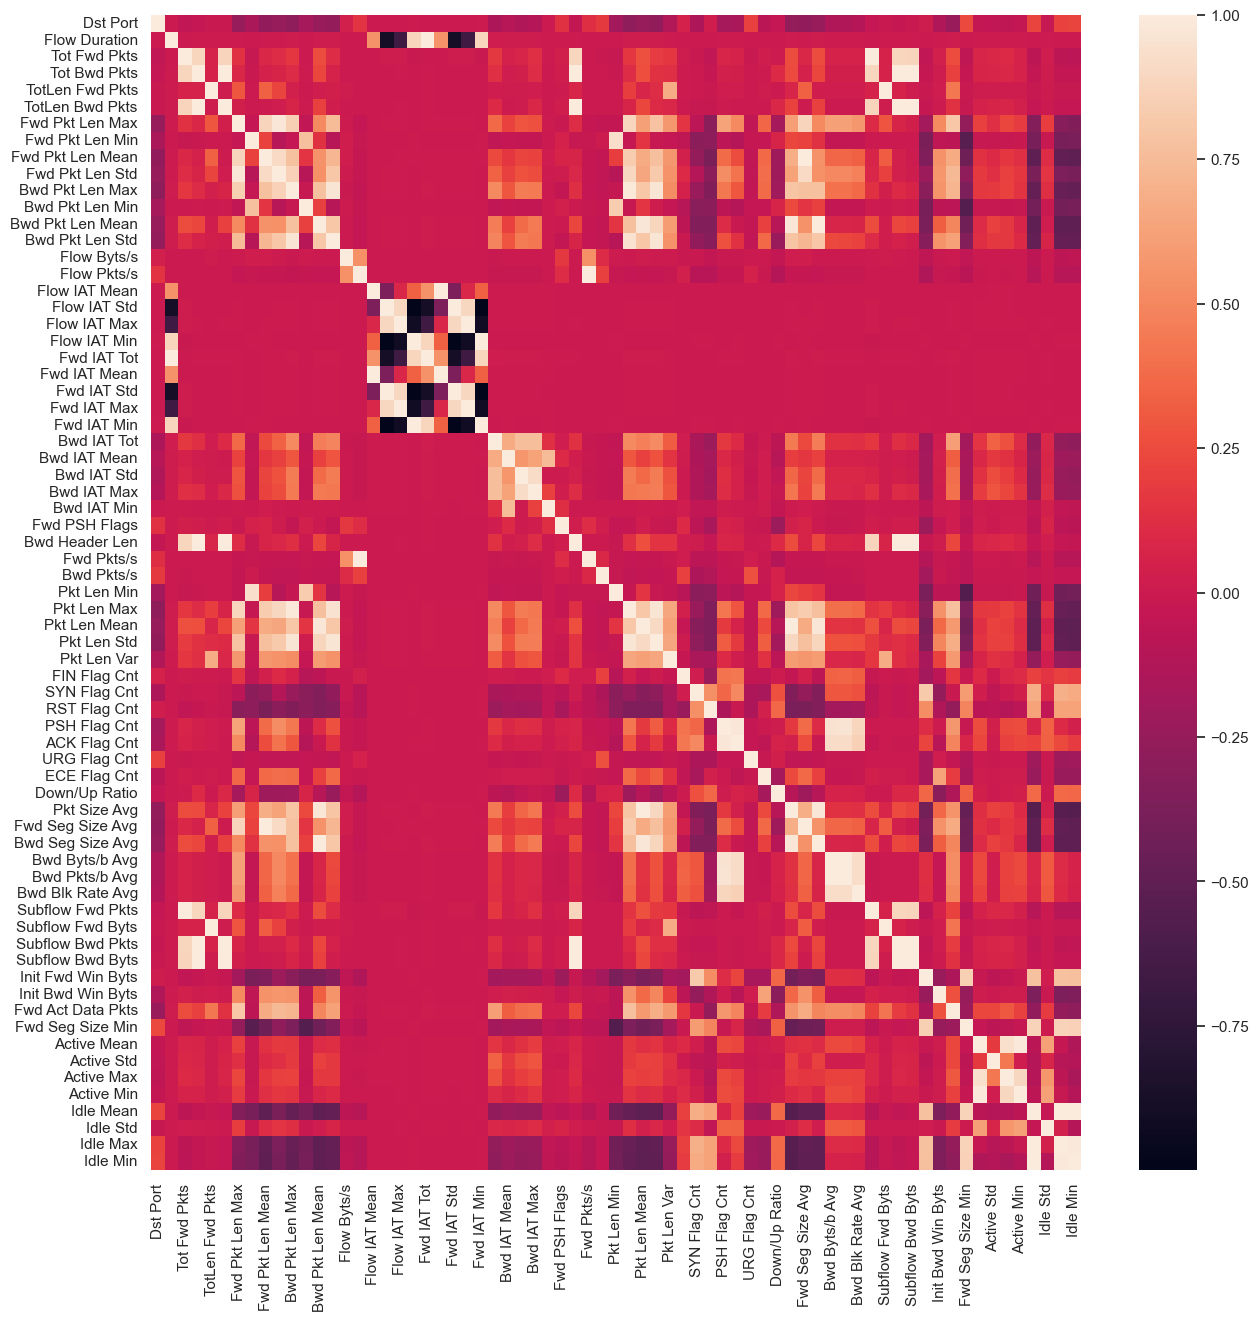

In [28]:
fig = plt.figure(figsize=(15, 15))
sns.set(font_scale=1.0)
ax = sns.heatmap(dataset_corr, annot=False)
fig.savefig(os.path.join('./images', 'correlation matrix.pdf'))

In [29]:
# Create & Apply mask
mask = np.triu(np.ones_like(dataset_corr, dtype=bool))
tri_df = dataset_corr.mask(mask)

# Find Features that meet the threshold
correlated_features = [c for c in tri_df.columns if any(tri_df[c] > 0.98)]
print(correlated_features)
# Drop the highly correlated features
df.drop(labels=correlated_features, axis=1, inplace=True)

['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Bwd Header Len', 'Pkt Len Mean', 'Bwd Byts/b Avg', 'Subflow Bwd Pkts', 'Active Mean', 'Idle Mean', 'Idle Max']


In [30]:
# drop columns
print(df.info())
train_dataset = df
print(train_dataset['Label'].value_counts())
# df.to_csv('./final_1/final_had_p.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2071552 entries, 0 to 2166272
Data columns (total 50 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int64  
 1   Fwd Pkt Len Max    float64
 2   Fwd Pkt Len Min    float64
 3   Fwd Pkt Len Std    float64
 4   Bwd Pkt Len Min    float64
 5   Bwd Pkt Len Std    float64
 6   Flow Byts/s        float64
 7   Fwd IAT Tot        float64
 8   Fwd IAT Mean       float64
 9   Fwd IAT Std        float64
 10  Fwd IAT Max        float64
 11  Fwd IAT Min        float64
 12  Bwd IAT Tot        float64
 13  Bwd IAT Mean       float64
 14  Bwd IAT Std        float64
 15  Bwd IAT Max        float64
 16  Bwd IAT Min        float64
 17  Fwd PSH Flags      int64  
 18  Fwd Pkts/s         float64
 19  Bwd Pkts/s         float64
 20  Pkt Len Min        float64
 21  Pkt Len Max        float64
 22  Pkt Len Std        float64
 23  Pkt Len Var        float64
 24  FIN Flag Cnt       int64  
 25  SYN Flag Cnt      

In [31]:
# encode label
labelE = LabelEncoder()
train_dataset['Label'] = labelE.fit_transform(train_dataset['Label'])
train_dataset['Label'].value_counts()
y = train_dataset['Label']
train_dataset = train_dataset.drop(['Label'],axis=1)

In [32]:
# normalize data
sc = StandardScaler()
train_dataset = sc.fit_transform(train_dataset)
train_dataset = pd.DataFrame(train_dataset,columns=df.columns[:-1])

In [33]:
# split data
X_train, X_test, y_train, y_test = train_test_split(train_dataset, y, test_size=0.1, random_state=42)

In [34]:
def re_shape(X_train,X_test,y_train,y_test):
    X_train = X_train.to_numpy().reshape(len(X_train),X_train.shape[1],1)
    X_test = X_test.to_numpy().reshape(len(X_test),X_test.shape[1],1)
    return X_train,X_test,y_train,y_test



def mutil_head_double_layers_evaluate_model(time,Xtrain,ytrain,Xtest,ytest,logdir,epochs=10,batch_size=128,lr =0.001):
    input1s = Input(shape=(Xtrain.shape[1],1))
    conv1d_1s1 = Conv1D(filters=32,kernel_size=3,activation='relu',padding='same')(input1s)
    batch_1s1 = BatchNormalization()(conv1d_1s1)
    maxpool_1s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_1s1)
    conv1d_1s2 = Conv1D(filters=32,kernel_size=3,activation='relu',padding='same')(maxpool_1s1)
    batch_1s2 = BatchNormalization()(conv1d_1s2)
    maxpool_1s2 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_1s2)
    flat1 = Flatten()(maxpool_1s2)

    input2s = Input(shape=(Xtrain.shape[1],1))
    conv1d_2s1 = Conv1D(filters=64,kernel_size=5,activation='relu',padding='same')(input2s)
    batch_2s1 = BatchNormalization()(conv1d_2s1)
    maxpool_2s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_2s1)
    conv1d_2s2 = Conv1D(filters=64,kernel_size=5,activation='relu',padding='same')(maxpool_2s1)
    batch_2s2 = BatchNormalization()(conv1d_2s2)
    maxpool_2s2 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_2s2)
    flat2 = Flatten()(maxpool_2s2)
    
    input3s = Input(shape=(Xtrain.shape[1],1))
    conv1d_3s1 = Conv1D(filters=128,kernel_size=7,activation='relu',padding='same')(input3s)
    batch_3s1 = BatchNormalization()(conv1d_3s1)
    maxpool3 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_3s1)
    conv1d_3s2 = Conv1D(filters=128,kernel_size=7,activation='relu',padding='same')(maxpool3)
    batch_3s2 = BatchNormalization()(conv1d_3s2)
    maxpool_3s2 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_3s2)
    flat3 = Flatten()(maxpool_3s2)

    concat = concatenate([flat1,flat2])
    dense1 = Dense(256,activation='relu')(concat)
    drop = Dropout(0.2)(dense1)
    dense2 = Dense(4,activation='softmax')(drop)
    model = Model(inputs=[input1s,input2s],outputs=dense2)
    #plot model
    plot_model(model, to_file=f'models/{time}/model_{time}.png', show_shapes=True, show_layer_names=True)

    opt = SGD(lr=lr, momentum=0.9)  
    model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    logdir = logdir + time
    tensorboard_callback = TensorBoard(log_dir=logdir)
    calls = [tensorboard_callback,
            #  EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto'),
            #  ModelCheckpoint(filepath=f'models/{time}/model_{time}.h5',monitor='val_loss',save_best_only=True,mode='auto'),
            #  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=1,mode='auto',min_delta=0.0001,cooldown=0,min_lr=0)
            ]
    model.fit([Xtrain,Xtrain],ytrain,epochs=epochs,batch_size=batch_size,validation_data=([Xtest,Xtest],ytest),callbacks=calls,verbose=1)
    # _,acc = model.evaluate([Xtest,Xtest,Xtest],ytest,verbose=0)
    # print("Accuracy: %.2f%%" % (acc*100))
    return model

def mutil_head_double_layers_evaluate_model1(time,Xtrain,ytrain,Xtest,ytest,logdir,epochs=10,batch_size=128,lr =0.001):
    input1s = Input(shape=(Xtrain.shape[1],1))
    conv1d_1s1 = Conv1D(filters=32,kernel_size=3,activation='relu',padding='same')(input1s)
    batch_1s1 = BatchNormalization()(conv1d_1s1)
    maxpool_1s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_1s1)
    flat1 = Flatten()(maxpool_1s1)

    input2s = Input(shape=(Xtrain.shape[1],1))
    conv1d_2s1 = Conv1D(filters=64,kernel_size=5,activation='relu',padding='same')(input2s)
    batch_2s1 = BatchNormalization()(conv1d_2s1)
    maxpool_2s1 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_2s1)
    flat2 = Flatten()(maxpool_2s1)
    
    input3s = Input(shape=(Xtrain.shape[1],1))
    conv1d_3s1 = Conv1D(filters=128,kernel_size=7,activation='relu',padding='same')(input3s)
    batch_3s1 = BatchNormalization()(conv1d_3s1)
    maxpool3 = MaxPooling1D(pool_size=3,strides=2,padding='same')(batch_3s1)
    flat3 = Flatten()(maxpool3)

    concat = concatenate([flat1,flat2])
    dense1 = Dense(1024,activation='relu')(concat)
    drop1 = Dropout(0.5)(dense1)

    dense2 = Dense(256,activation='relu')(drop1)
    drop2 = Dropout(0.5)(dense2)
    dense3 = Dense(4,activation='softmax')(drop2)
    model = Model(inputs=[input1s,input2s],outputs=dense3)
    #plot model
    plot_model(model, to_file=f'models/{time}/model_{time}.png', show_shapes=True, show_layer_names=True)

    opt = SGD(lr=lr, momentum=0.9)  
    model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    logdir = logdir + time
    tensorboard_callback = TensorBoard(log_dir=logdir)
    calls = [tensorboard_callback,
            #  EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto'),
            #  ModelCheckpoint(filepath=f'models/{time}/model_{time}.h5',monitor='val_loss',save_best_only=True,mode='auto'),
            #  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=1,mode='auto',min_delta=0.0001,cooldown=0,min_lr=0)
            ]
    model.fit([Xtrain,Xtrain],ytrain,epochs=epochs,batch_size=batch_size,validation_data=([Xtest,Xtest],ytest),callbacks=calls,verbose=1)
    # _,acc = model.evaluate([Xtest,Xtest,Xtest],ytest,verbose=0)
    # print("Accuracy: %.2f%%" % (acc*100))
    return model

In [35]:
X_train,X_test,y_train,y_test = re_shape(X_train,X_test,y_train,y_test)

In [36]:
# %tensorboard --logdir logs/fit
time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
os.mkdir(f'./models/{time}')
logdir="logs/multi/" + time +'/'
model = mutil_head_double_layers_evaluate_model1(time,X_train,y_train,X_test,y_test,logdir,20,512)
model.save(f'models/{time}/model_{time}.h5')

c:\Users\fancyma\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
3642/3642 [==============================] - 42s 11ms/step - loss: 0.2659 - accuracy: 0.9003 - val_loss: 0.2995 - val_accuracy: 0.9049
Epoch 2/20
3642/3642 [==============================] - 41s 11ms/step - loss: 0.2445 - accuracy: 0.9078 - val_loss: 0.2382 - val_accuracy: 0.9114
Epoch 3/20
3642/3642 [==============================] - 41s 11ms/step - loss: 0.2420 - accuracy: 0.9087 - val_loss: 0.2374 - val_accuracy: 0.9116
Epoch 4/20
3642/3642 [==============================] - 42s 12ms/step - loss: 0.2406 - accuracy: 0.9092 - val_loss: 0.2422 - val_accuracy: 0.9108
Epoch 5/20
3642/3642 [==============================] - 41s 11ms/step - loss: 0.2399 - accuracy: 0.9094 - val_loss: 0.2400 - val_accuracy: 0.9103
Epoch 6/20
3642/3642 [==============================] - 42s 11ms/step - loss: 0.2392 - accuracy: 0.9096 - val_loss: 0.2354 - val_accuracy: 0.9115
Epoch 7/20
3642/3642 [==============================] - 42s 12ms/step - loss: 0.2386 - accuracy: 0.9098 - val_loss: 0.2361 -

In [37]:
da = pd.DataFrame(y_test)
da.value_counts()

Label
0        57791
1        49984
3        49849
2        49532
dtype: int64

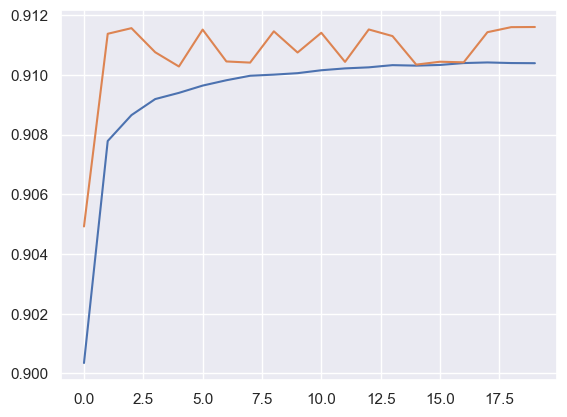

In [38]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])